In [ ]:
!pip install tensorflow-gpu==2.0.0

In [56]:
import pandas as pd
import numpy as np
import seaborn as sns
import cv2
import os
from imutils import paths
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from warnings import filterwarnings 
from sklearn.metrics import roc_auc_score, roc_curve, cohen_kappa_score, classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt 
from google.colab import drive
from random import randint

In [4]:
filterwarnings("ignore")
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
os.chdir("/content/drive/MyDrive/Colab Notebooks")

In [18]:
des = sorted(list(paths.list_images("chest_xray")))
x = []
y = []
data = []
with tqdm(total = len(des)) as pbar:
    for i in des:
        try:
            image = cv2.imread(i)
            pic = cv2.resize(image,(224,224))
            image = cv2.resize(image, (28,28))
            data.append(pic)
            image = img_to_array(image)
            x.append(image)
            y.append(i.split(sep = "/")[-2])
        except:
            continue
        pbar.update(1)

  0%|          | 0/5856 [00:00<?, ?it/s]

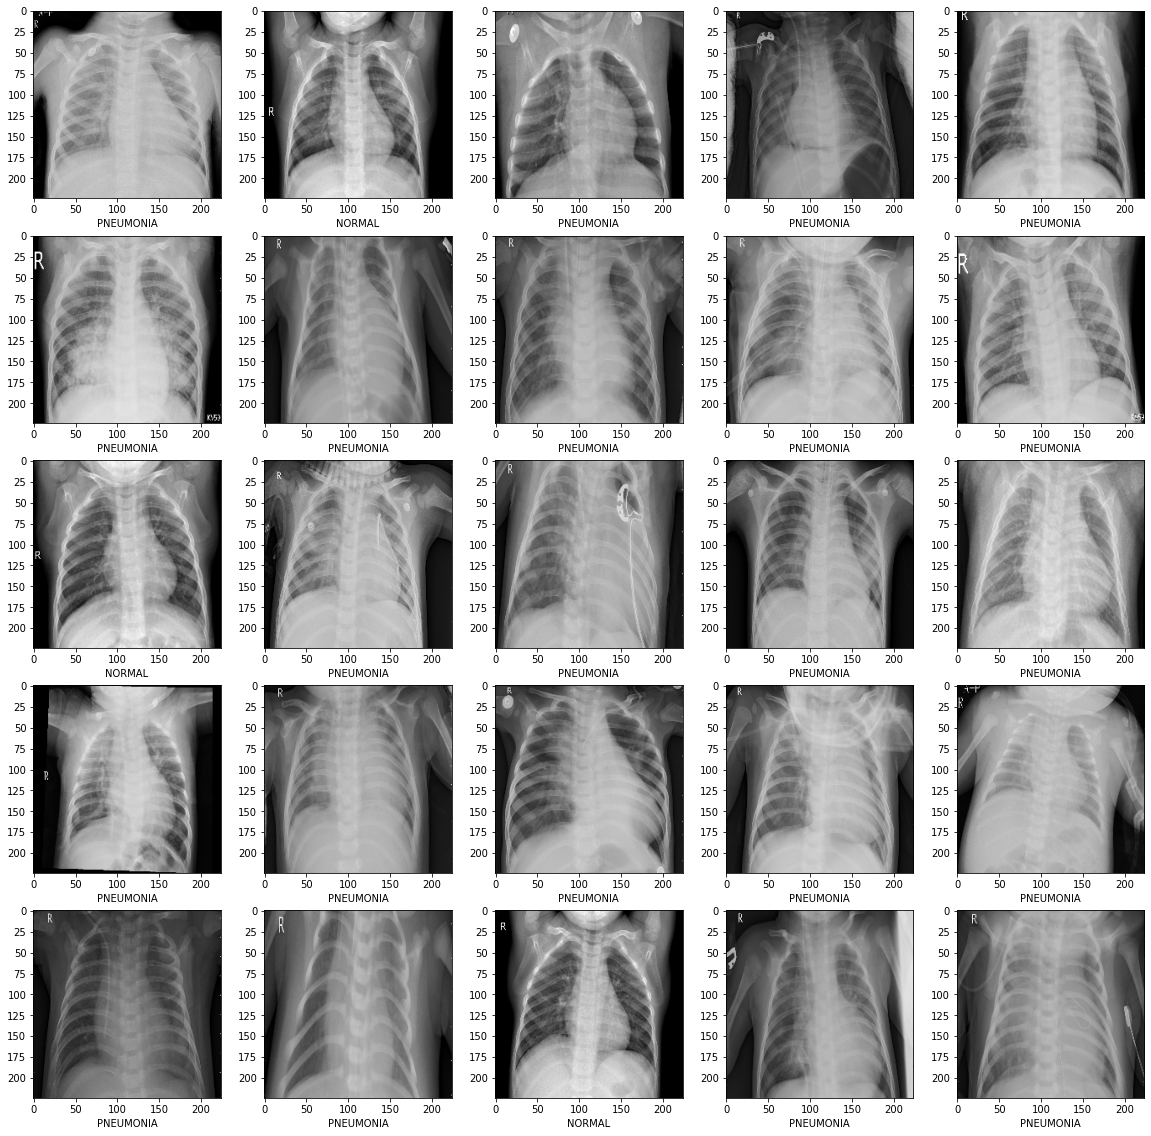

In [19]:
l_grid = 5
w_grid = 5
fig, ax = plt.subplots(nrows= l_grid, ncols =w_grid,figsize=(20,20))
for i in ax.flatten():
    k = randint(0, len(x))
    i.imshow(data[k])
    i.set_xlabel(y[k])
plt.show()

In [20]:
label_mapping = {"NORMAL":0, "PNEUMONIA":1}
y_new = [label_mapping[i] for i in y]

In [21]:
x_final = np.array(x, dtype = "float")
y_final = np.array(y_new)

In [22]:
df = pd.Series(y_final)
df.value_counts()

1    4273
0    1583
dtype: int64

In [29]:
x_train, x_test, y_train, y_test = train_test_split(x_final,y_final, test_size = 0.2, random_state = 10)

In [30]:
model = Sequential([Conv2D(20, (5,5), padding = "same"),
                    Activation("relu"),
                    MaxPooling2D(pool_size = (2,2), strides= (1,1)),
                    Conv2D(20, (5,5), padding = "same"), 
                    Activation("relu"),
                    MaxPooling2D(pool_size = (2,2), strides= (1,1)),
                    Flatten(),
                    Dense(units = 512, activation = "relu"),
                    Dense(units = 512, activation = "relu"),
                    Dense(units = 512, activation = "relu"),
                    Dense(1, activation = "sigmoid")                   
    ])

model.compile(optimizer = Adam(),
                  loss = "binary_crossentropy",
                  metrics = ["accuracy"])

In [33]:
len(x_train)

4684

In [41]:
H= model.fit(x = x_train,y= y_train, validation_split = 0.1, steps_per_epoch = 281, epochs = 50)

Train on 4215 samples, validate on 469 samples
Epoch 1/50
4215/4215 [==============================] - 38s 9ms/sample - loss: 0.1774 - accuracy: 0.9371 - val_loss: 0.2728 - val_accuracy: 0.9275
Epoch 2/50
4215/4215 [==============================] - 43s 10ms/sample - loss: 0.1415 - accuracy: 0.9490 - val_loss: 0.2441 - val_accuracy: 0.9488
Epoch 3/50
4215/4215 [==============================] - 39s 9ms/sample - loss: 0.1604 - accuracy: 0.9378 - val_loss: 0.2818 - val_accuracy: 0.9232
Epoch 4/50
4215/4215 [==============================] - 39s 9ms/sample - loss: 0.1451 - accuracy: 0.9459 - val_loss: 0.2635 - val_accuracy: 0.9403
Epoch 5/50
4215/4215 [==============================] - 37s 9ms/sample - loss: 0.1282 - accuracy: 0.9497 - val_loss: 0.2837 - val_accuracy: 0.9467
Epoch 6/50
4215/4215 [==============================] - 36s 9ms/sample - loss: 0.1271 - accuracy: 0.9495 - val_loss: 0.2152 - val_accuracy: 0.9296
Epoch 7/50
4215/4215 [==============================] - 36s 8ms/sample

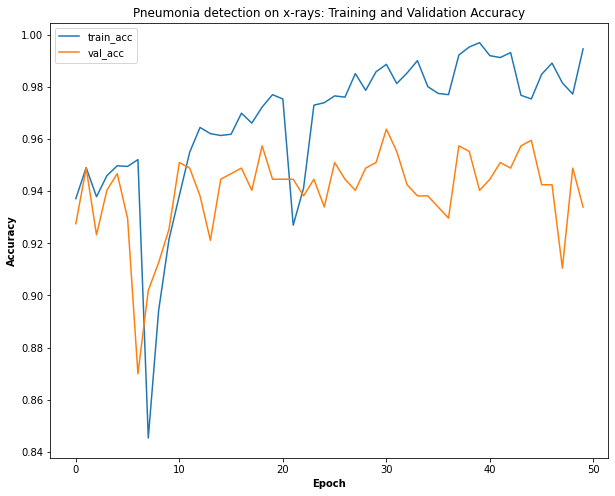

In [43]:
Epochs = 50
plt.figure(figsize = [10,8])
plt.plot(np.arange(0, Epochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, Epochs), H.history["val_accuracy"], label="val_acc")
plt.title("Pneumonia detection on x-rays: Training and Validation Accuracy")
plt.xlabel("Epoch", weight="bold")
plt.ylabel("Accuracy", weight="bold")
plt.legend()
plt.show()

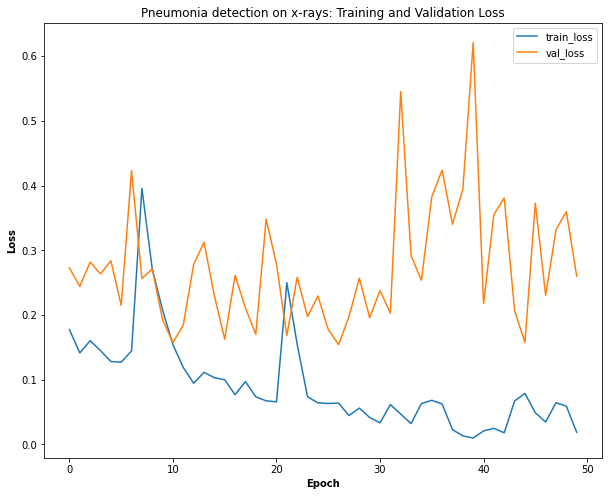

In [44]:
plt.figure(figsize = [10,8])
plt.plot(np.arange(0, Epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, Epochs), H.history["val_loss"], label="val_loss")
plt.title("Pneumonia detection on x-rays: Training and Validation Loss")
plt.xlabel("Epoch", weight="bold")
plt.ylabel("Loss", weight="bold")
plt.legend()
plt.show()

In [48]:
y_pred_prob = model.predict(x_test)

In [49]:
def plot_roc(y_pred_prob):
    fpr, tpr, threshold = roc_curve(y_test, y_pred_prob)
    fig = plt.figure(figsize= (20,15))
    plt.plot(fpr,tpr)
    plt.plot([0,1],"r--")
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.text(x = 0.02, y = 0.85, s = ("AUC Score: ", roc_auc_score(y_test, y_pred_prob)))
    plt.title('ROC Curve for Vehicle Detection', fontsize = 15)
    plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
    plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)
    plt.grid(True)

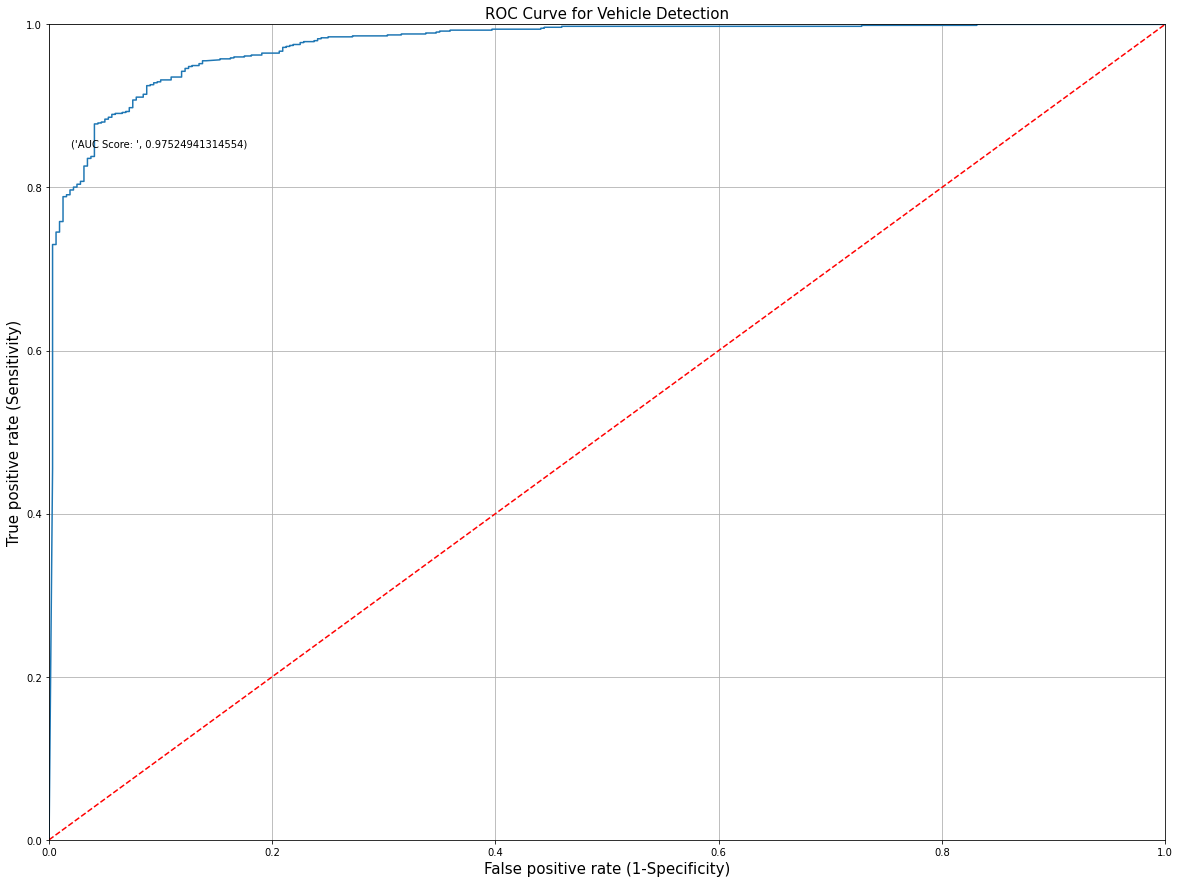

In [51]:
plot_roc(y_pred_prob)

In [95]:
y_pred = [1 if i>0.4 else 0 for i in y_pred_prob]

In [96]:
def model_evaluation(y_test, y_pred):
    print("Cohen Kappa Score:", cohen_kappa_score(y_test, y_pred), "\n")
    print("Classification Report--> \n", classification_report(y_test,y_pred))
    cm = confusion_matrix(y_test, y_pred)
    cm = pd.DataFrame(cm)
    sns.heatmap(cm, annot =True, fmt ="d")
    plt.xlabel("Predicted Class")
    plt.ylabel("Actual Class")

Cohen Kappa Score: 0.7929678499562218 

Classification Report--> 
               precision    recall  f1-score   support

           0       0.92      0.78      0.85       320
           1       0.92      0.97      0.95       852

    accuracy                           0.92      1172
   macro avg       0.92      0.88      0.90      1172
weighted avg       0.92      0.92      0.92      1172



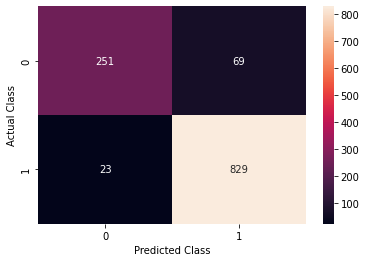

In [97]:
model_evaluation(y_test, y_pred)

In [ ]:
!pip install gradio

In [102]:
def predict_image(image):
    data_pred  = []
    im = cv2.resize(image, (28, 28))
    image = img_to_array(image)
    data_pred.append(image)
    d = np.array(data_pred, dtype = "float")
    preds = model.predict(d)
    pred = 1 if preds>=0.4 else 0 
    l = pd.Series(label_mapping)  
    return l[l == pred].index
predict_image(x_test[4])

Index(['PNEUMONIA'], dtype='object')

In [106]:
import gradio as gr
def predict_image(image):
    data_pred  = []
    im = cv2.resize(image, (28, 28))
    image = img_to_array(image)
    data_pred.append(image)
    d = np.array(data_pred, dtype = "float")
    preds = model.predict(d)
    pred = "PNEUMONIA" if preds>=0.4 else "NORMAL"
    return pred

ima = gr.inputs.Image(shape=(28,28))
label = gr.outputs.Label()

gr.Interface(fn=predict_image, inputs=ima, outputs=label,capture_session=True, title="Pneumonia detection on x-rays").launch(share=True, debug = True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://2a80f3705959e75b.gradio.app

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


Keyboard interruption in main thread... closing server.


(<gradio.routes.App at 0x7fd5be9a8450>,
 'http://127.0.0.1:7864/',
 'https://2a80f3705959e75b.gradio.app')